# IF + F + XGBoost


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Veri setini yükleyip gereksiz sütunları çıkarıyoruz.
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerleri düzeltme
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [2]:
# Aykırı değerlerin tespiti
data_for_outlier = X.copy()
data_for_outlier[target] = y

iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
outlier_pred = iso_forest.fit_predict(data_for_outlier)

mask = outlier_pred == 1
print(f"Toplam örnek sayısı: {len(data_for_outlier)}")
print(f"Aykırı tespit edilen örnek sayısı: {np.sum(outlier_pred == -1)}")

X_clean = X[mask]
y_clean = y[mask]

Toplam örnek sayısı: 1692
Aykırı tespit edilen örnek sayısı: 286


In [3]:


# Pipeline oluşturuluyor:
# - İlk adımda, SelectKBest ile f_regression kullanarak her fold için eğitim verisi üzerinde en iyi 10 özellik seçiliyor.
# - İkinci adımda, seçilen özelliklerle XGBoost modeli eğitiliyor.
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('model', xgb.XGBRegressor(random_state=42))
])

# 10 katlı KFold tanımlıyoruz.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# cross_validate ile her fold’da pipeline'ı fit ediyoruz.
# return_estimator=True sayesinde her fold'da oluşturulan estimator (pipeline) listesine erişebiliyoruz.
cv_results = cross_validate(pipeline, X_clean, y_clean, cv=kfold, return_estimator=True)

# Her fold için seçilen özellikleri ekrana yazdırıyoruz.
# cv_results['estimator'] listesindeki her bir pipeline, kendi eğitim verisi üzerinden feature selection yapmıştır.
for i, est in enumerate(cv_results['estimator'], start=1):
    mask_selected = est.named_steps['feature_selection'].get_support()
    selected_feature_names = X_clean.columns[mask_selected]
    print(f"Fold {i} seçilen özellikler: {list(selected_feature_names)}")

# Tahminleri elde etmek için cross_val_predict kullanıyoruz.
y_pred = cross_val_predict(pipeline, X_clean, y_clean, cv=kfold)

# Performans metriklerini hesaplıyoruz.
mae = mean_absolute_error(y_clean, y_pred)
mape = mean_absolute_percentage_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R2 Score: {r2}")



Fold 1 seçilen özellikler: ['basarili_satis_adet', 'basarili_satis_ciro', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'Yıl', 'Ay']
Fold 2 seçilen özellikler: ['basarili_satis_ciro', 'Müşteri Skoru', 'bıst100_Açılış', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'USD_Kapanış', 'USD_Yüksek', 'Yıl']
Fold 3 seçilen özellikler: ['basarili_satis_ciro', 'basarili_iade_adet', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'Yıl', 'Ay']
Fold 4 seçilen özellikler: ['basarili_satis_ciro', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'USD_Kapanış', 'USD_Yüksek', 'Yıl']
Fold 5 seçilen özellikler: ['basarili_iade_ciro', 'Müşteri Skoru', 'bıst100_Kapanış', 'bıst100_Açılış', 'bıst100_Yüksek', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'Yıl']
Fold 6 seçilen özellikler: ['basarili_satis_adet', 'basarili_satis_ciro'

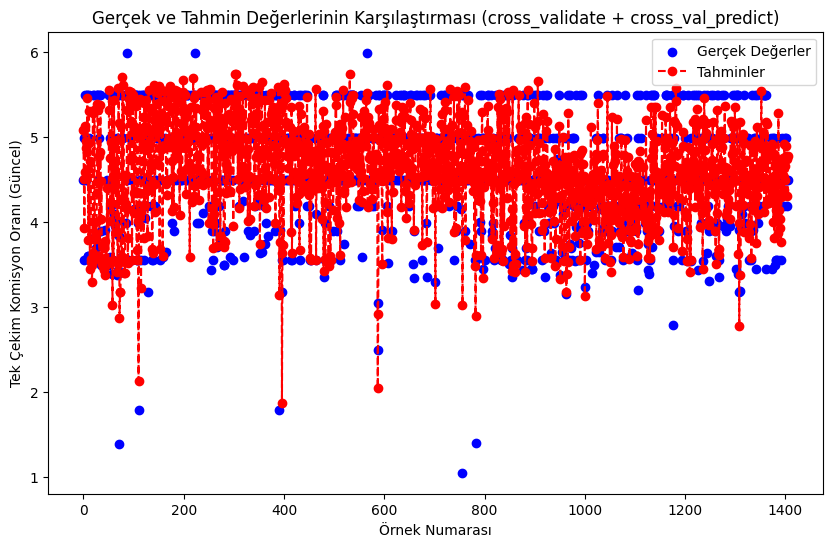

In [4]:
# Sonuçları görselleştiriyoruz.
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean)), y_clean, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred)), y_pred, color="red", linestyle="--", marker="o", label="Tahminler")
plt.title("Gerçek ve Tahmin Değerlerinin Karşılaştırması (cross_validate + cross_val_predict)")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Veri setini yükleyip gereksiz sütunları çıkarıyoruz.
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerleri düzeltme
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

# Aykırı değerlerin tespiti
data_for_outlier = X.copy()
data_for_outlier[target] = y

iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
outlier_pred = iso_forest.fit_predict(data_for_outlier)

mask = outlier_pred == 1
print(f"Toplam örnek sayısı: {len(data_for_outlier)}")
print(f"Aykırı tespit edilen örnek sayısı: {np.sum(outlier_pred == -1)}")

X_clean = X[mask]
y_clean = y[mask]

# Pipeline oluşturuluyor:
# - İlk adımda, SelectKBest ile f_regression kullanarak eğitim verisi üzerinden en iyi 10 özellik seçiliyor.
# - İkinci adımda, seçilen özelliklerle XGBoost modeli eğitiliyor.
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('model', xgb.XGBRegressor(random_state=42))
])

# 10 katlı KFold tanımlıyoruz.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# GridSearchCV için geniş parametre havuzu
param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__reg_alpha': [0, 0.1, 0.5, 1],
    'model__reg_lambda': [1, 1.5, 2, 3],
    'model__min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_clean, y_clean)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor (Neg MAE):", grid_search.best_score_)

# En iyi estimator ile tahminler yapılıyor
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_clean)

# Performans metriklerini hesaplıyoruz.
mae = mean_absolute_error(y_clean, y_pred)
mape = mean_absolute_percentage_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Grid Search - Mean Absolute Error (MAE): {mae}")
print(f"Grid Search - Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Grid Search - R2 Score: {r2}")

# Sonuçları görselleştiriyoruz.
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean)), y_clean, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred)), y_pred, color="red", linestyle="--", marker="o", label="Tahminler")
plt.title("Grid Search ile En İyi Parametreler Sonuçları")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Toplam örnek sayısı: 1692
Aykırı tespit edilen örnek sayısı: 286
Fitting 10 folds for each of 110592 candidates, totalling 1105920 fits


KeyboardInterrupt: 

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Toplam örnek sayısı: 1692
Aykırı tespit edilen örnek sayısı: 286
Fitting 10 folds for each of 1024 candidates, totalling 10240 fits
En iyi parametreler: {'model__gamma': 0, 'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__reg_alpha': 0}
En iyi skor (Neg MAE): -0.23667576426157716
Grid Search - Mean Absolute Error (MAE): 0.0012828010888730507
Grid Search - Mean Absolute Percentage Error (MAPE): 0.00027956269260546584
Grid Search - R2 Score: 0.9999897855173613


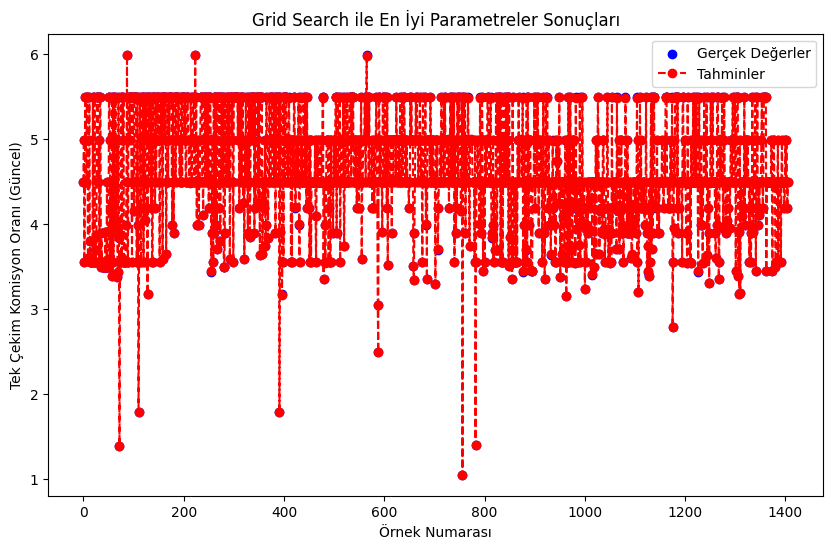

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Veri setini yükleyip gereksiz sütunları çıkarıyoruz.
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerleri düzeltme
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

# Aykırı değerlerin tespiti
data_for_outlier = X.copy()
data_for_outlier[target] = y

iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
outlier_pred = iso_forest.fit_predict(data_for_outlier)

mask = outlier_pred == 1
print(f"Toplam örnek sayısı: {len(data_for_outlier)}")
print(f"Aykırı tespit edilen örnek sayısı: {np.sum(outlier_pred == -1)}")

X_clean = X[mask]
y_clean = y[mask]

# Pipeline oluşturuluyor:
# - İlk adımda, SelectKBest ile f_regression kullanarak eğitim verisi üzerinden en iyi 10 özellik seçiliyor.
# - İkinci adımda, seçilen özelliklerle XGBoost modeli eğitiliyor.
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('model', xgb.XGBRegressor(random_state=42))
])

# 10 katlı KFold tanımlıyoruz.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# GridSearchCV için geniş parametre havuzu
param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__reg_alpha': [0, 0.1, 0.5, 1],

}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_clean, y_clean)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor (Neg MAE):", grid_search.best_score_)

# En iyi estimator ile tahminler yapılıyor
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_clean)

# Performans metriklerini hesaplıyoruz.
mae = mean_absolute_error(y_clean, y_pred)
mape = mean_absolute_percentage_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Grid Search - Mean Absolute Error (MAE): {mae}")
print(f"Grid Search - Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Grid Search - R2 Score: {r2}")

# Sonuçları görselleştiriyoruz.
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean)), y_clean, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred)), y_pred, color="red", linestyle="--", marker="o", label="Tahminler")
plt.title("Grid Search ile En İyi Parametreler Sonuçları")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()
